# Forecasting Weekly Department Sales using DeepAR in AWS 2번째 

- 출처 : [https://medium.com/slalom-data-analytics/forecasting-weekly-department-sales-using-deepar-in-aws-5f7de09d0916](https://medium.com/slalom-data-analytics/forecasting-weekly-department-sales-using-deepar-in-aws-5f7de09d0916)

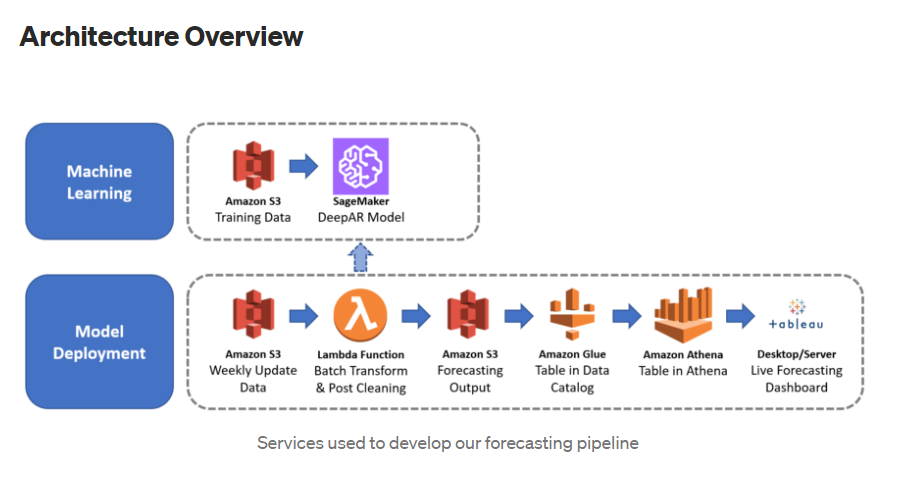

Now that we have a working model, next comes model deployment — that’s how we integrate the model we trained into a workflow to generate predictions for a business. 

To do that, the main services we use in AWS are S3, Lambda, Glue, and Athena. 

The Model Deployment flow in the above architecture diagram shows how this process will run once set up and automated.

S3 is our primary storage service where we store all historical data that we want to create a forecast on. 

As updates to the dataset are collected over time, they can easily be uploaded to the source bucket for this flow and the rest of the process will run fully automated.

We use Lambda to run a batch transform job to generate predictions and post-process the results into a format that we can easily consume. 

The Lambda function is triggered when new data are received in a S3 bucket.

Here, the assumption is that in a production environment, there will be another ETL process that writes clean data into this bucket on a weekly basis. 

Once the Lambda is triggered and run, it writes prediction results into CSV files in S3, which are then accessed by Glue and Athena. 

And finally, Tableau reads the data from Athena and shows the predictions in a dashboard.

이제 작동하는 모델이 있으므로 다음은 모델 배포입니다. 

이것이 우리가 훈련한 모델을 워크플로에 통합하여 비즈니스에 대한 예측을 생성하는 방법입니다. 

이를 위해 AWS에서 사용하는 주요 서비스는 S3, Lambda, Glue 및 Athena입니다. 

위 아키텍처 다이어그램의 모델 배포 흐름은 이 프로세스가 설정되고 자동화되면 어떻게 실행되는지 보여줍니다.

S3는 예측을 생성하려는 모든 과거 데이터를 저장하는 기본 스토리지 서비스입니다. 

데이터 세트에 대한 업데이트는 시간이 지남에 따라 수집되므로 소스 버킷에 쉽게 업로드할 수 있으며 나머지 프로세스는 완전히 자동화되어 실행됩니다.

Lambda를 사용하여 배치 변환 작업을 실행하여 예측을 생성하고 결과를 쉽게 사용할 수 있는 형식으로 후처리합니다. 

S3 버킷에 새 데이터가 수신되면 Lambda 함수가 트리거됩니다.

(트리거 : 사용자 가입, 확인 및 로그인(인증) 같은 사용자 풀 작업 시 Lambda 트리거를 사용하여 해당 함수를 시작할 수 있습니다. 인증 문제 추가, 사용자 마이그레이션 및 확인 메시지 사용자 지정을 수행할 수 있습니다.)

여기에서는 프로덕션 환경에서 매주 정리된 데이터를 이 버킷에 쓰는 또 다른 ETL 프로세스가 있다고 가정합니다. 

Lambda가 트리거되고 실행되면 S3의 CSV 파일에 예측 결과를 기록하고 Glue 및 Athena에 접근합니다. 

마지막으로 Tableau는 Athena에서 데이터를 읽고 대시보드에 예측을 표시합니다.



## Lambda

AWS Lambda is one of the most used AWS services. 

It is an event-driven, serverless computing platform. 

It lets you run code without provisioning or managing servers. 

The function only runs when trigged by predefined events and scales automatically. 

You only pay for the time when your code is running. This service supports code written in different languages, including Java and Python.

## 람다

AWS Lambda는 가장 많이 사용되는 AWS 서비스 중 하나입니다. 

이벤트 중심의 서버리스 컴퓨팅 플랫폼입니다. 

서버를 공급하거나 관리하지 않고도 코드를 실행할 수 있습니다.

함수는 사전 정의된 이벤트에 의해 트리거될 때만 실행되고 자동으로 측정됩니다.

코드가 실행되는 시간에 대해서만 비용을 지불합니다.

이 서비스는 Java 및 Python을 비롯한 다양한 언어로 작성된 코드를 지원합니다.

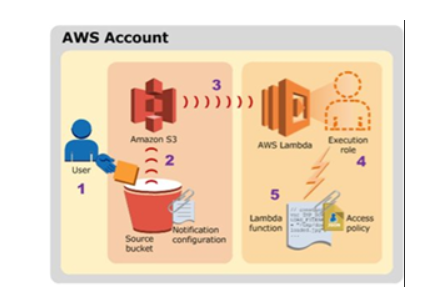

In [1]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입
Image("C://Users/MyCom/jupyter-tutorial/AWS/data/20220302_132245.png")

> 서버리스 컴퓨팅이란?

-출처 : [https://www.cloudflare.com/ko-kr/learning/serverless/what-is-serverless/](https://www.cloudflare.com/ko-kr/learning/serverless/what-is-serverless/)


서버리스 컴퓨팅은 사용량에 따라 백엔드 서비스를 제공하는 방법입니다. 서버리스 아키텍처로 사용자는 기본 인프라를 걱정하지 않고 코드를 작성하고 배포할 수 있습니다. 서버리스 업체로부터 백엔드 서비스를 받는 기업은 사용량에 따라 비용을 부과받으며 서비스 규모가 자동으로 결정되기 때문에 고정 대역폭이나 서버 개수를 유지하거나 그에 대한 비용을 지불하지 않아도 됩니다. 네임 서버리스에도 불구하고 물리적 서버는 여전히 사용되지만 개발자는 이를 인식할 필요가 없습니다.

웹 초기에는 웹 애플리케이션을 구축하려면 서버를 실행하기 위한 물리적 하드웨어를 보유해야 했고 이것은 귀찮고 비용이 많이 필요한 작업이었습니다.

일정량의 서버 공간을 원격으로 임대할 수 있는 클라우드 컴퓨팅이 등장했습니다. 이러한 고정 서버 공간을 대여한 개발자와 기업은 일반적으로 초과 구매하여 트래픽이나 활동 급증이 월간 한계를 초과하고 응용 프로그램을 중단시키지 않게 합니다. 이는 비용을 지불한 서버 공간의 상당 부분이 낭비될 수 있음을 의미합니다. 클라우드 업체는 자동 크기 조정 모델을 도입하여 이 문제를 해결하려 했지만 DDoS 공격 같은 원치 않는 활동 급증 때문에 많은 비용이 발생할 수 있습니다.

This diagram shows how AWS Lambda works in our workflow: 

an object, that is our prediction input data, is created in our S3 bucket. 

Once S3 detects the object created event, it triggers the Lambda function and executes the code with the input data creation event as a parameter. 

For S3 to trigger Lambda, we set up the permissions between our S3 input bucket and the Lambda function using our IAM role.

이 다이어그램은 AWS Lambda가 워크플로에서 어떻게 작동하는지 보여줍니다. 

예측 입력 데이터인 객체가 S3 버킷에서 생성됩니다. 

S3는 객체 생성 이벤트를 감지하면 Lambda 함수를 트리거하고 입력 데이터 생성 이벤트를 파라미터로 사용하여 코드를 실행합니다. 

S3가 Lambda를 트리거할 수 있도록 IAM 역할을 사용하여 S3 입력 버킷과 Lambda 함수 간에 권한을 설정합니다.

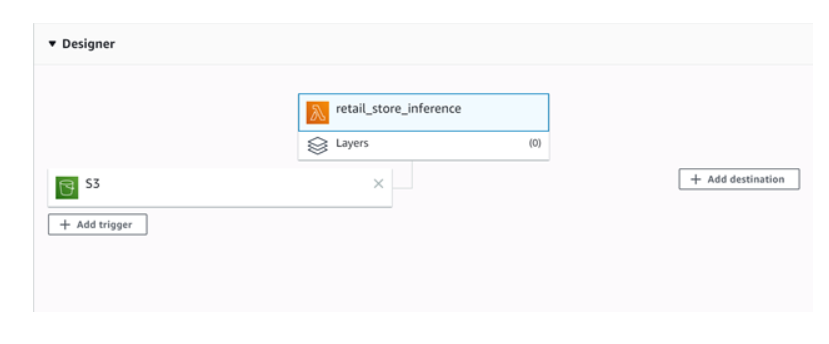

In [2]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입
Image("C://Users/MyCom/jupyter-tutorial/AWS/data/20220302_134103_1.png")

Inside the console for AWS Lambda, the designer shows the components of the service. 

The core components are the function and the trigger. 

A trigger is a service or resource that you have configured to invoke your function. 

Here, our trigger is configured to look for prediction data created in our S3 bucket. 

One Lambda function can support multiple triggers, so we can easily add another one here.

AWS Lambda용 콘솔 내에서, 디자이너는 서비스의 구성 요소를 보여줍니다. 

핵심 구성 요소는 함수와 트리거입니다.

트리거는 함수를 호출하도록 구성한 서비스 또는 자원입니다.

여기에서 트리거는 S3 버킷에서 생성된 예측 데이터를 찾도록 구성되어 있습니다. 

하나의 Lambda 함수는 여러 트리거를 지원할 수 있으므로 여기에 다른 하나를 쉽게 추가할 수 있습니다.


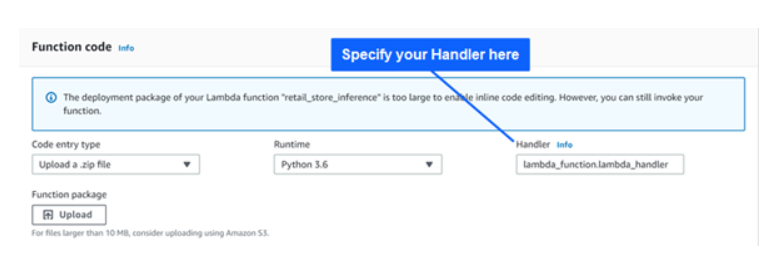

In [3]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입
Image("C://Users/MyCom/jupyter-tutorial/AWS/data/20220302_134806_1.png")

This is the Lambda function that creates our predictions and cleans the output.

A function is the code and the runtime to process events.

Runtime sets the language for the code — in our case, it is Python. 

A handler is the function that the Lambda runs when your function is executed. 

It has two components: the first is the file name and the second is the function name inside that file. 

Our handler for the function is named lambda_function.lambda_handler. 

The Lambda function passes the triggered event and the context to the handler when it’s triggered.


There are different ways to supply your code. 

You can write code directly in the editor if you don’t need any libraries. 

If you need to add libraries and dependencies other than the AWS SDK, or you use the Lambda API, you need to create a deployment package, which is a ZIP archive that contains the function code and dependencies. 

In our case, because we needed to use Pandas and Numpy to process the output, we created a deployment package and uploaded it directly. 

Another way to upload the package is to first upload it to S3 and then upload it within Lambda from S3.

이것은 예측을 생성하고 출력을 정리하는 Lambda 함수입니다.

함수는 이벤트를 처리하는 코드이자 런타임입니다. ( 런타임(영어: runtime→실행시간)은 컴퓨터 과학에서 컴퓨터 프로그램이 실행되고 있는 동안의 동작을 말한다. "런타임"이라는 용어는 컴퓨터 언어 안에 쓰인 프로그램을 관리하기 위해 특정한 컴파일러나 가상 머신이 사용하는 기본 코드의 라이브러리나 프로그램을 가리키는 런타임 라이브러리라고도 일컫는다.)

런타임은 코드의 언어를 설정합니다. 이 경우에는 Python입니다. 

핸들러는 함수가 실행될 때 Lambda가 실행하는 함수입니다. 

두 가지 구성 요소가 있습니다. 첫 번째는 파일 이름이고 두 번째는 해당 파일 내부의 함수 이름입니다. 

함수에 대한 핸들러의 이름은 lambda_function.lambda_handler입니다. 

Lambda 함수는 트리거될 때 트리거된 이벤트와 문맥이 핸들러에 전달합니다.


코드를 제공하는 다양한 방법이 있습니다. 

라이브러리가 필요하지 않은 경우 편집기에서 직접 코드를 작성할 수 있습니다.

AWS SDK 이외의 라이브러리 및 종속성을 추가해야 하거나 Lambda API를 사용하는 경우에는 함수 코드 및 종속성을 포함하는 ZIP 아카이브인 배포 패키지를 생성해야 합니다. 

우리의 경우 출력을 처리하기 위해 Pandas와 Numpy를 사용해야 했기 때문에 배포 패키지를 만들고 직접 업로드했습니다. 

패키지를 업로드하는 또 다른 방법은 먼저 패키지를 S3에 업로드한 다음 S3에서 Lambda 내에 업로드하는 것입니다.



AWS recommended best practices are to separate the Lambda handler from your core logic and use environment variables to pass operational parameters to your function. 

In our demo, we define a model_name variable to pass our DeepAR model. 

In the future, if we have a better performing model that we’d like to use, we can easily make the change in the environment variable section without the need to edit the function script.

You can also configure layers and destinations for your Lambda function, though neither are used in our demo.

Layers are used to pull in additional libraries and dependencies. 

A layer is a ZIP archive that contains those libraries or other dependencies. 

With layers, you can efficiently re-use external libraries in your function without the need to include them in your deployment package every time you need them. 

A destination is an AWS resource that receives details about invocation results for a function. 

Some information that could be passed include event details, invocation status, and invocation response.

AWS 권장 모범 사례는 핵심 로직에서 Lambda 핸들러를 분리하고 환경 변수를 사용하여 작동 매개변수를 함수에 전달하는 것입니다. 

데모에서는 DeepAR 모델을 전달하기 위해 model_name 변수를 정의합니다.

앞으로, 우리가 사용하고 싶은 더 나은 성능의 모델이 있다면 함수 스크립트를 편집할 필요 없이 환경 변수 섹션에서 쉽게 변경할 수 있습니다.

데모에서는 사용되지 않지만 Lambda 함수에 대한 계층과 대상을 구성할 수도 있습니다. 

레이어는 추가 라이브러리 및 종속성을 가져오는 데 사용됩니다. 

레이어는 해당 라이브러리 또는 기타 종속성을 포함하는 ZIP 아카이브입니다. 

레이어를 사용하면 필요할 때마다 배포 패키지에 포함할 필요 없이 함수에서 외부 라이브러리들을 효율적으로 재사용할 수 있습니다.

대상은 함수에 대한 호출 결과에 대한 세부 정보를 수신하는 AWS 리소스입니다. 

전달될 수 있는 일부 정보에는 이벤트 세부사항, 호출 상태 및 호출 응답이 포함됩니다.

## Glue and Athena


Once our Lambda function finishes running and writes cleaned prediction results back to S3, Glue and Athena access that data and prepare it for further analysis.

AWS Glue is a fully managed ETL service.

We set up a Glue Crawler to automatically extract the table schema of our prediction results and store that metadata in the Glue Data Catalog. 

Data Catalog is natively integrated with Amazon Athena, which is an interactive querying service. 

Athena conveniently accesses the prediction results in S3 through Data Catalog. 

At this point, we have a table ready within Athena that we can query using SQL to view the predictions. 

We can stop here, or as presented in the next section, we further connect Athena to Tableau and build a live dashboard for visualization.


Lambda 함수 실행이 완료되고 정리된 예측 결과를 다시 S3에 기록하면, Glue와 Athena가 해당 데이터에 접근하고 추가 분석을 위해 준비합니다.

AWS Glue는 완전 관리형 ETL 서비스입니다. 

예측 결과의 테이블 스키마를 자동으로 추출하고 해당 메타데이터를 Glue 데이터 카탈로그에 저장하도록 Glue Crawler를 설정했습니다.

Data Catalog는 기본적으로 대화형 쿼리 서비스인 Amazon Athena와 통합됩니다. 

Athena는 Data Catalog를 통해 S3의 예측 결과에 편리하게 접근합니다. 

이 시점에서, Athena 내에서 SQL을 사용하여 쿼리하여 예측을 볼 수 있는 테이블이 준비되어 있습니다. 

여기에서 멈추거나 다음 섹션에 설명된 대로, Athena를 Tableau에 추가로 연결하고 시각화를 위한 라이브 대시보드를 구축할 수 있습니다.



## Live Forecasting Dashboard

Many data visualization software options offer live connections to AWS services. 

We’ve decided to use Tableau to build a live forecasting dashboard that visualizes the predictions from our DeepAR model once they exist in Amazon Athena. 

Establishing this connection is a simple process. Follow the steps provided by Tableau here.

Once connected, you can easily build any visualization that suits your needs. The dashboard below shows new predictions in blue for both stores and departments.

## 실시간 예측 대시보드

많은 데이터 시각화 소프트웨어 옵션은 AWS 서비스에 실시간 연결을 제공합니다.

우리는 Tableau를 사용하여 Amazon Athena에 존재하는 DeepAR 모델의 예측을 시각화하는 실시간 예측 대시보드를 구축하기로 결정했습니다.

이 연결을 설정하는 것은 간단한 프로세스입니다.

여기에서 Tableau에서 제공하는 단계를 따르십시오.

일단 연결되면, 필요에 맞는 시각화를 쉽게 구축할 수 있습니다. 

아래 대시보드는 매장과 부서 모두에 대한 새로운 예측을 파란색으로 표시합니다.

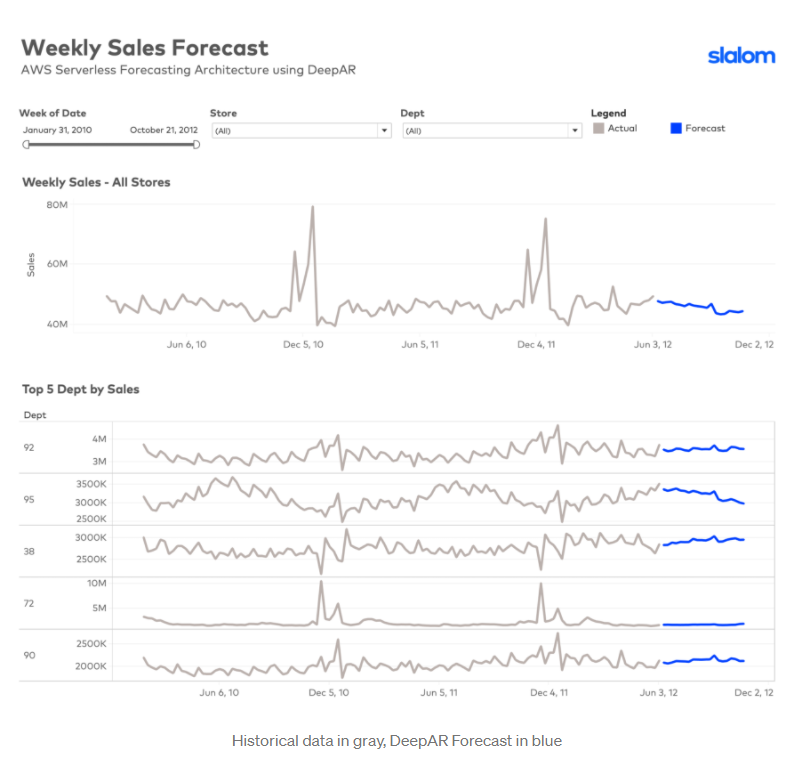

In [4]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입
Image("C://Users/MyCom/jupyter-tutorial/AWS/data/20220302_144624_1.png")

Given that this is a Live connection, as soon as updated store data is landed in S3, the model and subsequent ETL processes will be triggered and the resulting predictions will automatically appear in Tableau.

While this process demonstrates a weekly batch inference job, this pipeline could be utilized to enable more frequent prediction intervals as well, with the primary dependency being the time required for model inference and post-inference data processing.


실시간 연결인 경우, 업데이트된 매장 데이터가 S3에 도착하는 즉시, 모델 및 후속 ETL 프로세스들이 트리거되고 결과 예측이 Tableau에 자동으로 나타납니다.

이 프로세스는 주간 배치 추론 작업을 보여주지만, 이 파이프라인은 모델 추론 및 추론 후 데이터 처리에 필요한 시간인 주요 종속성과 함께 보다 빈번한 예측 간격을 활성화하는 데에도 활용될 수 있습니다.


## Concluding Thoughts

The AWS suite offers every service required for quick and easy forecasting on a large scale. 

Amazon’s pre-built algorithms and deployment services don’t take much configuration to create an end-to-end pipeline that is fully automated. 

There can be a bit of a learning curve when using SageMaker models since the documentation, although comprehensive, can be difficult to search through. 

All things considered, we found this combination of S3, SageMaker (DeepAR), Lambda, Glue, and Athena to be a great solution to a problem faced countless times. 

If your forecasting problem involves generating predictions for many different entities, we recommend you consider this as one of your best solutions.



## 결론

AWS 제품군은 대규모의 빠르고 쉬운 예측에 필요한 모든 서비스를 제공합니다.

Amazon의 사전 구축된 알고리즘 및 배포 서비스는 완전히 자동화된 종단 간 파이프라인을 생성하는 데 많은 구성이 필요하지 않습니다.

문서는 포괄적이기는 하지만 검색하기 어려울 수 있으므로 SageMaker 모델을 사용할 때 약간의 학습 곡선이 있을 수 있습니다.

모든 것을 고려했을 때, 우리는 S3, SageMaker(DeepAR), Lambda, Glue 및 Athena의 조합이 수없이 직면한 문제에 대한 훌륭한 솔루션이라는 것을 알았습니다.

예측 문제에 다양한 엔터티에 대한 예측 생성이 포함되는 경우 이를 최상의 솔루션 중 하나로 고려하는 것이 좋습니다.